# EDA and visualization of the Ten Thousand German News Articles Dataset
In this notebook I will explore the dataset using different visualizations libraries.
I'll use the articles.csv file (must be in project root folder)

## Imports

In [ ]:
# FOR COLAB : need to download some libraries
!pip install sentence-transformers umap-learn

In [3]:
# Data manipulation
import pandas as pd
import numpy as np
from collections import Counter
import re
import umap
from sklearn.preprocessing import OrdinalEncoder
# NLP
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import download as nltk_download
from sentence_transformers import SentenceTransformer
# Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Only need to download the first time :
nltk_download('stopwords')
nltk_download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Loading Dataset

In [7]:
articles_df = pd.read_csv('articles.csv', sep=';', header = None, names = ['label','text'])

In [8]:
articles_df

,label,text
0,Etat,"Die ARD-Tochter Degeto hat sich verpflichtet, ..."
1,Etat,App sei nicht so angenommen worden wie geplant...
2,Etat,"'Zum Welttag der Suizidprävention ist es Zeit,..."
3,Etat,Mitarbeiter überreichten Eigentümervertretern ...
4,Etat,Service: Jobwechsel in der Kommunikationsbranc...
...,...,...
10268,Wissenschaft,Die Fundstelle in Südengland ist Unesco-Weltku...
10269,Wissenschaft,Im Team arbeitet auch ein Inspektor der sudane...
10270,Wissenschaft,Die zentrale Frage des Projekts: Siedelten Ägy...
10271,Wissenschaft,Klimatische Verschlechterungen dürften zur Auf...


## Text Basic Statistics

First I will print some basic distributions in the dataset :
* Distribution at character level
* Distribution at word level
* Distribution of average word lengths

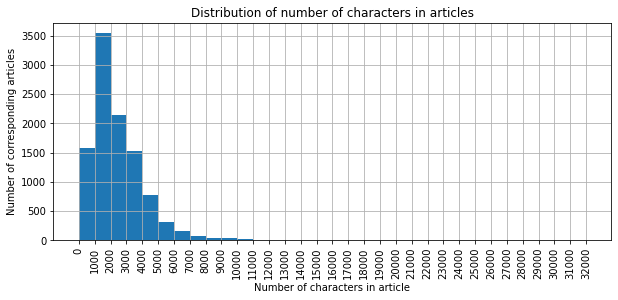

In [9]:
char_nb_df = articles_df['text'].str.len()
char_bins = [i for i in range(0,char_nb_df.max(),1000)]
char_nb_df.hist(bins=char_bins, xrot=90, figsize=(10,4))
plt.xticks(char_bins)
plt.xlabel('Number of characters in article')
plt.ylabel('Number of corresponding articles')
plt.title('Distribution of number of characters in articles')
plt.show()

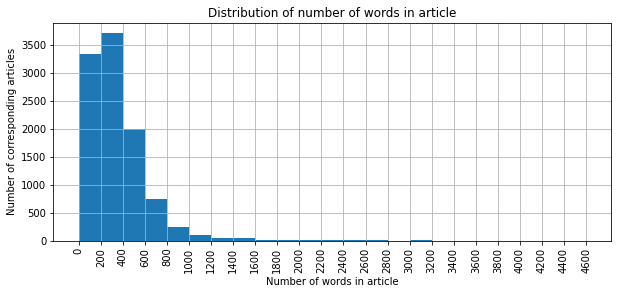

In [10]:
word_nb_df = articles_df['text'].str.split().map(lambda x: len(x))
word_bins = [i for i in range(0,word_nb_df.max(),200)]
word_nb_df.hist(bins=word_bins, xrot=90, figsize=(10,4))
plt.xticks(word_bins)
plt.xlabel('Number of words in article')
plt.ylabel('Number of corresponding articles')
plt.title('Distribution of number of words in article')
plt.show()

The major part of the dataset has articles containing less than 600 words , this will be useful to know when we tokenize the news articles for BERT, as BERT has to define a maximum sequence length for his inputs (using padding or truncation if necessary). 

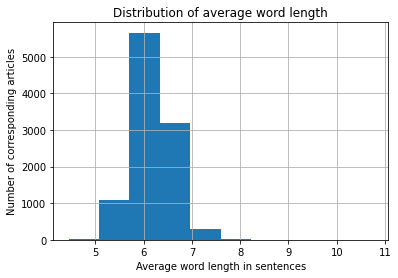

In [11]:
avg_word_len_df = articles_df['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
avg_word_len_df.hist()
plt.xlabel('Average word length in sentences')
plt.ylabel('Number of corresponding articles')
plt.title('Distribution of average word length')
plt.show()

German language usually has long words (lots of compound words) and the average number of character in german is 6.7 according to [this article](https://www.inter-contact.de/en/blog/text-length-languages?dt=1636454594184). So the articles we're using seems to follow this rule.

## Word frequency statistics

I will now try to analyze which are the most frequent words in the dataset. Stopwords have to be removed to have a better insight about the articles statistics, as well as punctuation. I will use NLTK to extract german stopwords list and strip strings of punctuation using regular expression

In [12]:
german_stop_words = stopwords.words('german')
del_punctuation = lambda x: re.sub(r'[^\w\s]', '', x)
texts =  articles_df.text.str.lower().apply(del_punctuation).str.split().values.tolist()
corpus=[word for i in texts for word in i if word not in german_stop_words]

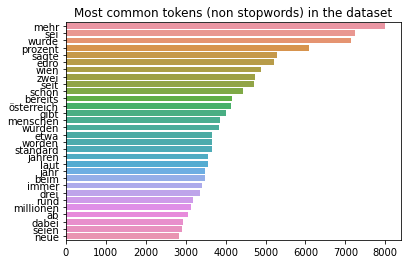

In [13]:
counter=Counter(corpus)
most=counter.most_common(30)
x, y=[], []
for word,count in most:
    if (word not in german_stop_words):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)
plt.title("Most common tokens (non stopwords) in the dataset")
plt.show()

Then I will try to see which non alpha tokens are mostly present in the dataset (to have insight about using number or not)

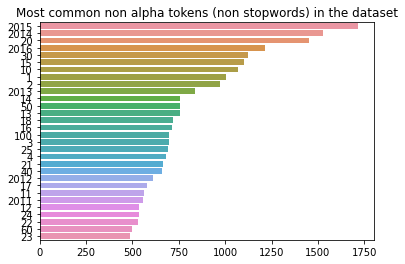

In [15]:
counter=Counter([word for word in corpus if not word.isalpha()])
most=counter.most_common(30)
x, y=[], []
for word,count in most:
    if (word not in german_stop_words):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)
plt.title("Most common non alpha tokens (non stopwords) in the dataset")
plt.show()

Non alpha tokens are mostly years , interesting fact is that years are sorted from most recent  (except for 2016,  it may be because the data was extracted during 2016 so there lacks a part of the year?); this can show that the numbers of articles published per year increase with time (with internet constant growth) .

## Classes Analyses

### Classes Repartition

First, we visualize the repartition of articles in the classes

,text
label,
Etat,668
Inland,1015
International,1511
Kultur,539
Panorama,1678
Sport,1201
Web,1677
Wirtschaft,1411
Wissenschaft,573


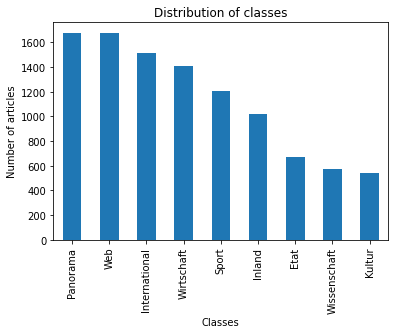

In [16]:
articles_df['label'].value_counts().plot(kind='bar', 
                                         title= 'Distribution of classes', 
                                         ylabel= 'Number of articles',
                                         xlabel= 'Classes')
articles_df.groupby(['label']).count()

We can see that classes are not balanced. So it will be important to take care of it during the train/test split (so that we have an even amount of each classes in train set and test set).

### Visualizing most frequent words in each class

In [17]:
# removing german stopwords and lowercasing articles and then cast them into a new column
articles_df["preprocessed_text"] = articles_df['text'].apply(del_punctuation).apply(lambda article :' '.join([word.lower() for word in word_tokenize(article) if word.lower() not in german_stop_words]))

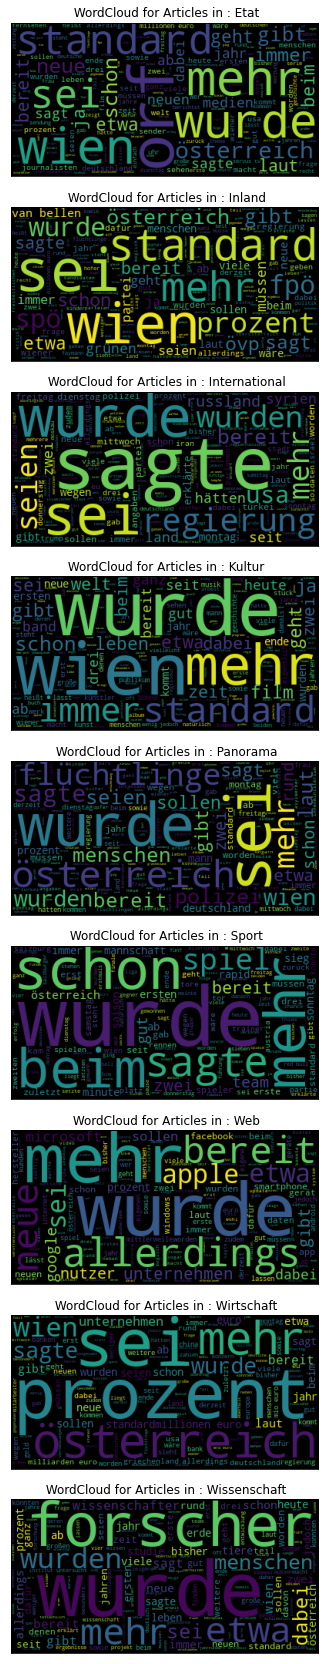

In [18]:
unique_labels = articles_df.label.unique() # array of unique labels
n_labels = len(unique_labels)# number of labels
fig, axes = plt.subplots(n_labels,1,figsize=(30,30)) # initializing one plot for each label
i = 0
for label in unique_labels: # iterating through all labels
    # Generating word cloud from joined articles in current label
    wordcloud = WordCloud().generate(' '.join(articles_df[articles_df['label']==label]['preprocessed_text'] ))
    axes[i].imshow(wordcloud)
    # Removing x and y axis because useless when visualizing word clouds
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    axes[i].set_title(" WordCloud for Articles in : " + label)
    i+=1

### Using sentence embeddings to visualize classes datapoints

I will use a [Sentence-Transformer Pretrained Model](https://www.sbert.net/docs/pretrained_models.html) to embed the articles sentences and then reduce their dimensions using UMAP for visualization.
I chose one of the mutilingual models with best performance according to authors as there were no models for german specifically on sentence transformers.
You can run this step on GPU for faster encoding of articles.

In [20]:
# Embedding articles using sentence transformers
model = SentenceTransformer('distiluse-base-multilingual-cased-v1', device='cuda') # run on CUDA for faster inference
embeddings = model.encode(articles_df["preprocessed_text"], show_progress_bar=True)

Batches:   0%|          | 0/322 [00:00<?, ?it/s]

In [21]:
# Doing dimension reduction with UMAP
umap_embedding = umap.UMAP(n_neighbors = 30, random_state=42).fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [22]:
ord = OrdinalEncoder()
num_labels = ord.fit_transform(articles_df['label'].values.reshape(len(articles_df['label']),1))
print("CLASS MAPPING :")
for i in range(n_labels):
  print(f"{i} --> {ord.inverse_transform(np.array([[i]]))[0]}")

CLASS MAPPING :
0 --> ['Etat']
1 --> ['Inland']
2 --> ['International']
3 --> ['Kultur']
4 --> ['Panorama']
5 --> ['Sport']
6 --> ['Web']
7 --> ['Wirtschaft']
8 --> ['Wissenschaft']


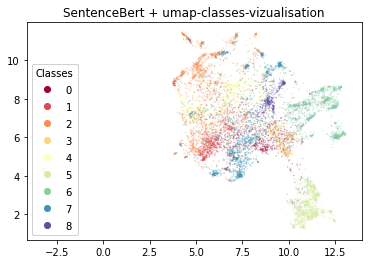

In [23]:
fig, ax = plt.subplots()
scatter = ax.scatter(umap_embedding.T[0], umap_embedding.T[1], s=0.03, c=num_labels, cmap='Spectral')
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.title("SentenceBert + umap-classes-vizualisation")
plt.show()

We can see that some classes are isolated from the others like class n°5 (Sport) or class n° 6 (Web) and others are a little bit mixed together (so they will probably be harder to classify). Indeed, as shown in the word clouds, some classes share the same most frequent words so some are more similar than others. Globally the colors representing the classes seems more or less clustered together so overall, after training, the model should perform correctly.